In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Define the loader method

In [20]:
def load_plumed(fname, line_lim=np.Inf):
    data = {}
    with open(fname, 'r') as f:
        fields = f.readline()[:-1].split(" ")[2:] # last char is '/n' and the first two are '#!' and 'FIELDS'
        for field in fields: # add fields to the colvars dict
            data[field] = []
        line_cnt = 0
        while (line_cnt<line_lim): # read up to LINE_LIM lines
            line = f.readline()
            if not line:
                break
            if line[0] == "#": # Don't read comments
                continue
            
            line_list = line.split()
            try: # account for incomplete files (useful when the sims is still running)
                for i, field in enumerate(fields):
                    data[field].append(float(line_list[i]))
            except:
                break
            finally:
                line_cnt += 1
    try:
        print("Read {} lines with {} headings. Last timestamp: {}".format(line_cnt, len(fields), data['time'][-1]))
    except:
        print("Read {} lines with {} headings. No timestamps available.".format(line_cnt, len(fields)))
    return data

In [21]:
LINE_LIM = np.Inf

## Read the COLVAR file

In [22]:
colvars = load_plumed("COLVAR", LINE_LIM)
headers = [i for i in colvars.keys()][1:]

Read 3003245 lines with 8 headings. Last timestamp: 600000.0


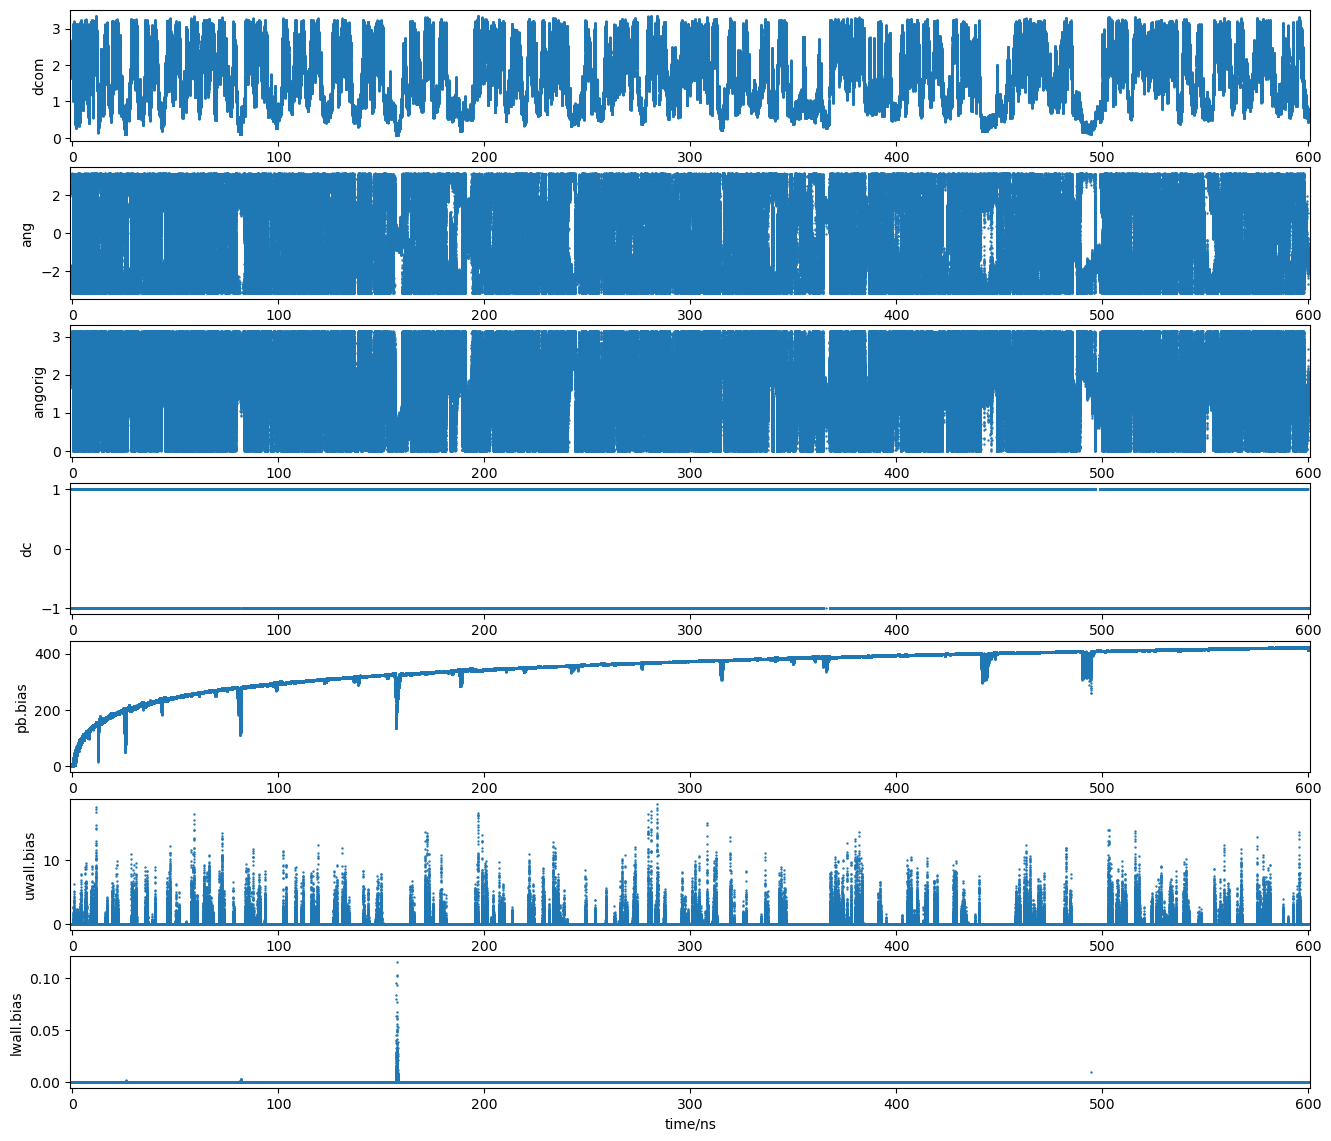

In [23]:
fig, axs = plt.subplots(len(headers), 1, dpi=100, figsize=(16, 2*len(headers)))
for i in range(len(headers)):
    axs[i].scatter(np.array(colvars['time'])/1000, colvars[headers[i]], s=0.5)
    axs[i].set_ylabel(f"{headers[i]}")
axs[-1].set_xlabel("time/ns")
for ax in axs:
    ax.set_xlim(-1, (np.array(colvars['time'])/1000)[-1]+1)
plt.show()

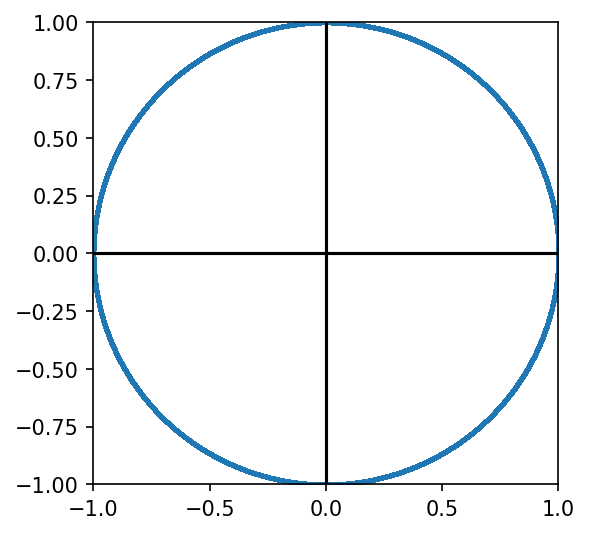

In [24]:
colvars = pd.DataFrame(colvars)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.scatter(np.cos(colvars.ang), np.sin(colvars.ang), s=0.5)
ax.hlines([0], xmin=-1, xmax=1, colors='k')
ax.vlines([0], ymin=-1, ymax=1, colors='k')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.show()

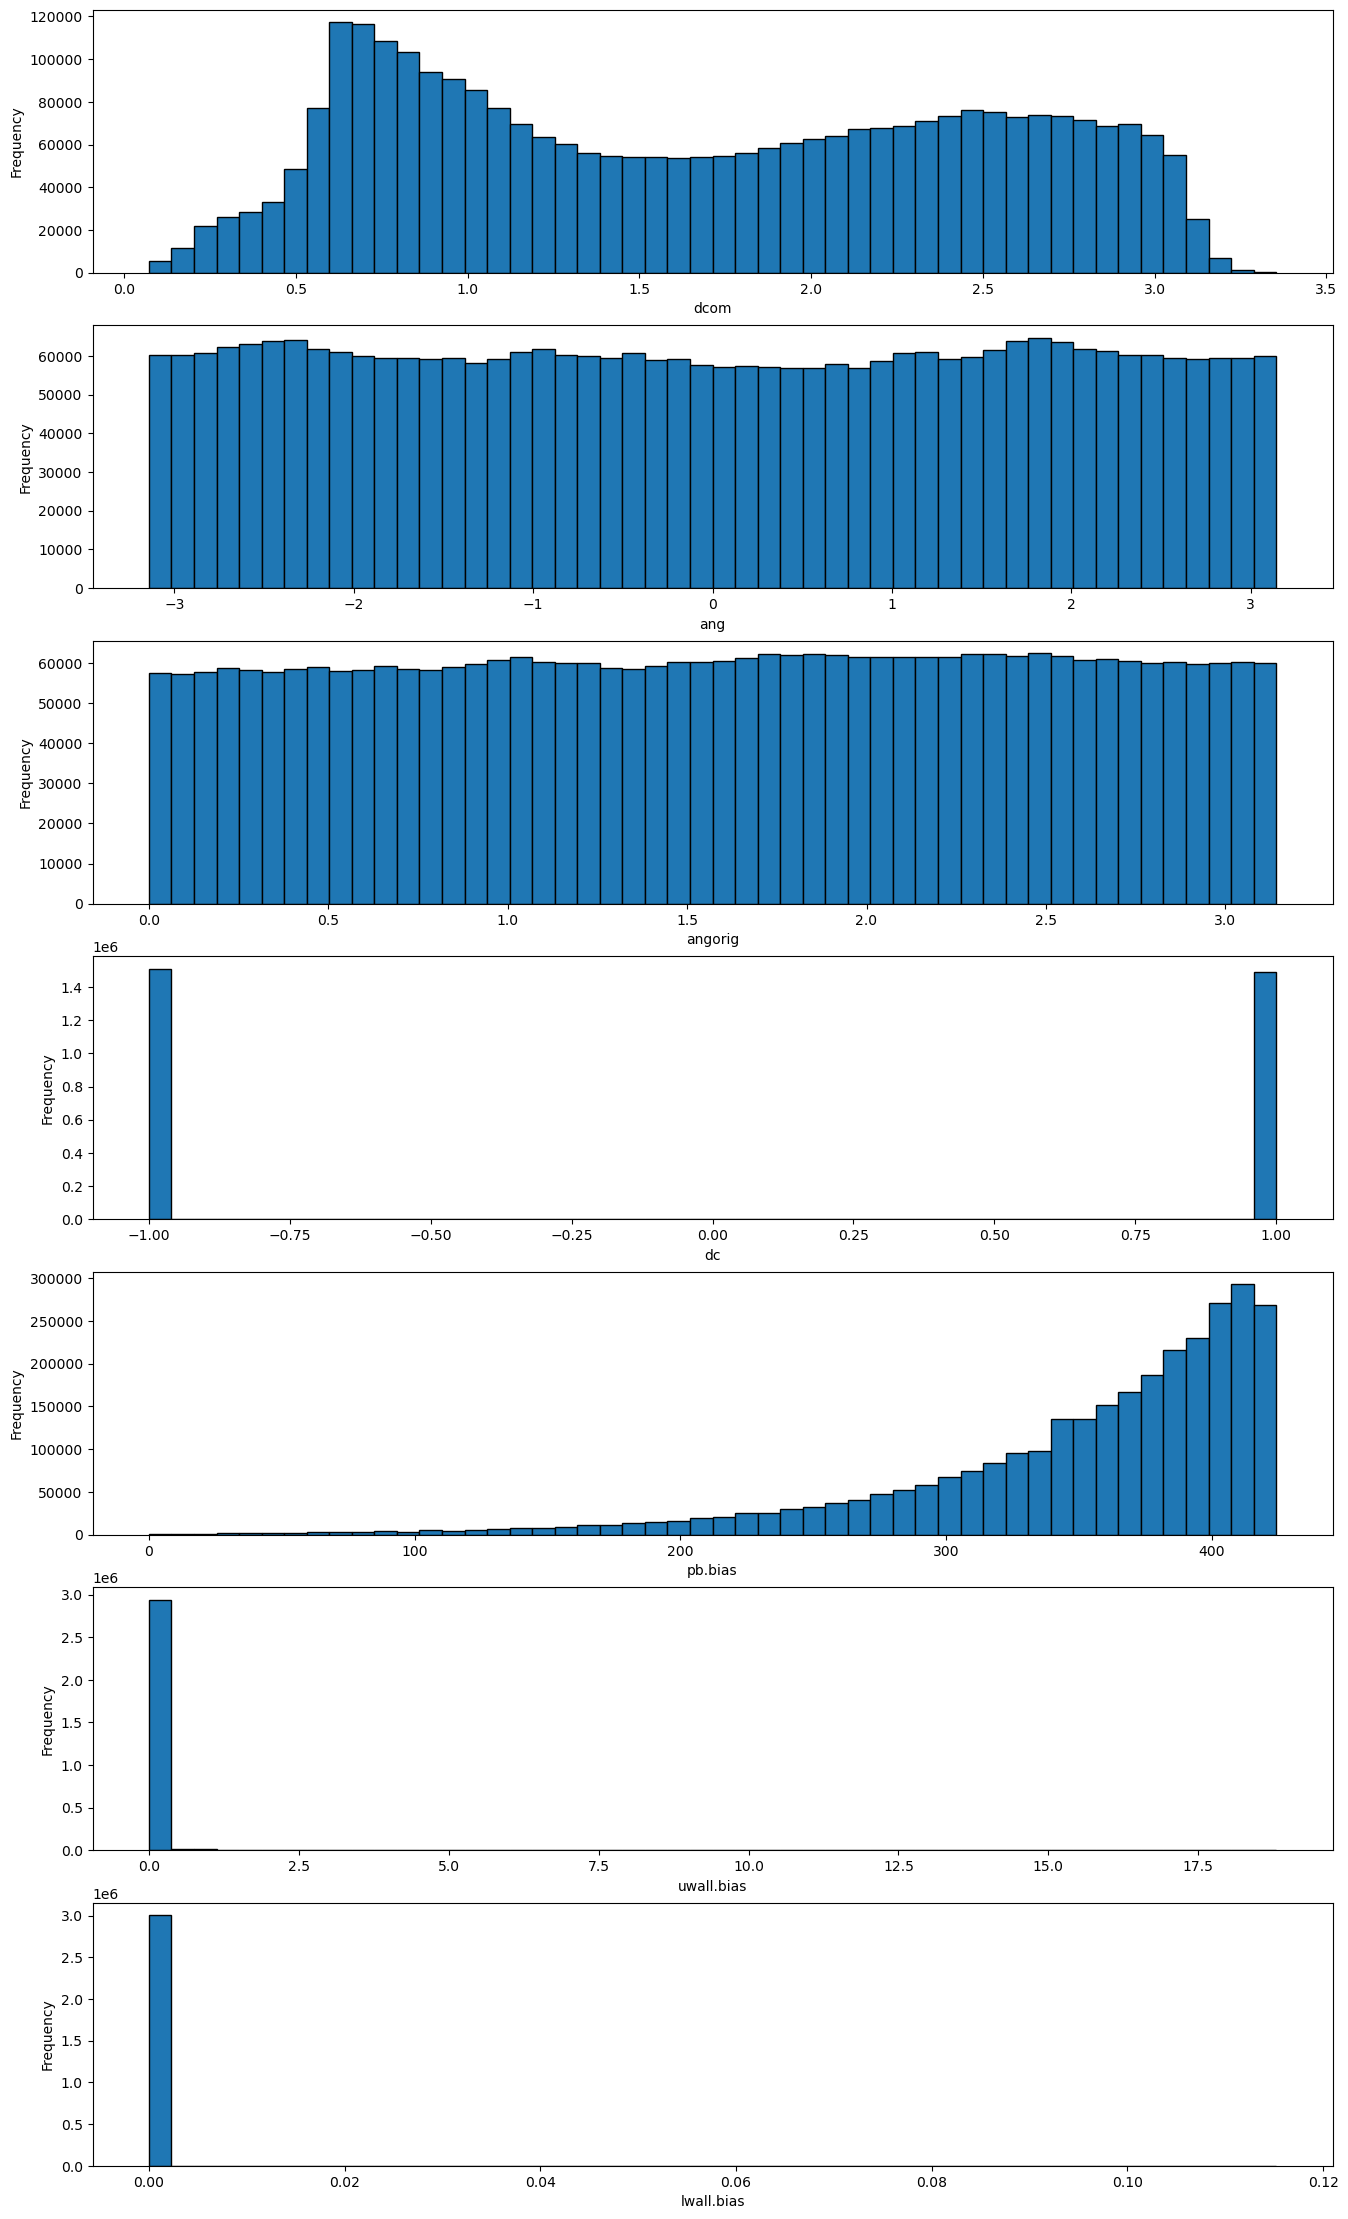

In [25]:
fig, axs = plt.subplots(len(headers), 1, dpi=100, figsize=(16, 4*len(headers)))
for i in range(len(headers)):
    axs[i].hist(colvars[headers[i]], bins=50, edgecolor='k')
    axs[i].set_xlabel(f"{headers[i]}")
    axs[i].set_ylabel("Frequency")
plt.show()

## Read the HILLS file

In [26]:
import os
files = os.listdir(".")
hills_files = []
for file in files:
    if "HILLS" in file and "." not in file:
        hills_files.append(file)
hills = [i.split("_")[-1] for i in hills_files]
hills = {i:None for i in hills}

for key in hills.keys():
    hills[key] = pd.DataFrame(load_plumed(f"HILLS_{key}", LINE_LIM))

Read 600648 lines with 5 headings. Last timestamp: 600000.0
Read 600648 lines with 5 headings. Last timestamp: 600000.0


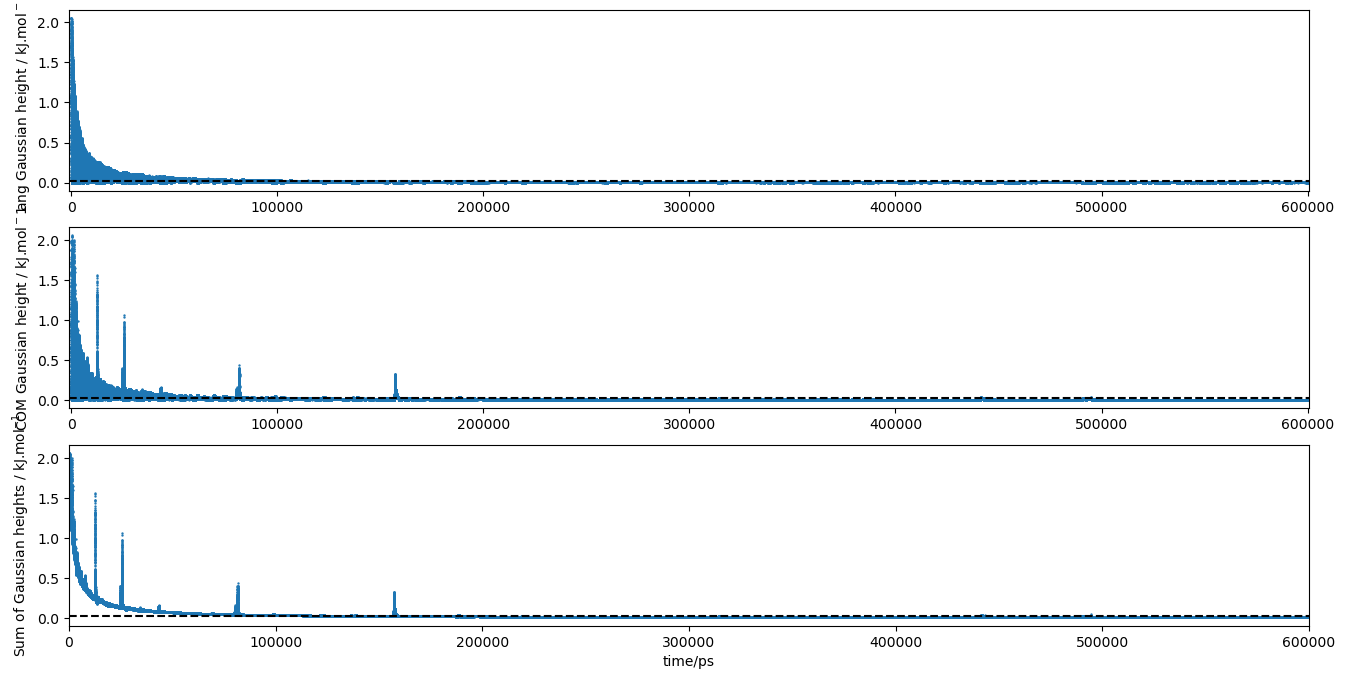

In [27]:
fig, axs = plt.subplots(len(hills_files)+1, 1, dpi=100, figsize=(16, len(hills_files)*4))
for i, key in enumerate(hills.keys()):
    heights = np.array(hills[key]['height'])
    axs[i].scatter(range(len(heights)), heights, s=0.5)
    axs[i].set_ylabel(fr"{key} Gaussian height / kJ.mol$^{-1}$")
    max_hill = np.max(heights)
    axs[i].hlines(0.01*max_hill, -1000, len(heights)+1, linestyle='dashed', color='k')
#    axs[i].set_ylim(0, 0.11*max_hill)
    axs[i].set_xlim(-1000, len(heights)+1)
# SUMS
hills_sum = {}#np.zeros_like(hills['COM']['height'])
for i, key in enumerate(hills.keys()):
    heights = np.array(hills[key]['height'])
    times = np.array(hills[key]['time'])
    for i, time in enumerate(times):
        hills_sum[time] = hills_sum.get(time, 0) + heights[i]
axs[-1].scatter(list(hills_sum.keys()), list(hills_sum.values()), s=0.5)
axs[-1].set_ylabel(r"Sum of Gaussian heights / kJ.mol$^{-1}$")
hills_max = max(list(hills_sum.values()))
time_max = max(list(hills_sum.keys()))
axs[-1].hlines(0.01*hills_max, -1, time_max+1, linestyle='dashed', color='k')
#axs[-1].set_ylim(0, 0.11*hills_max)
axs[-1].set_xlim(-1, time_max+1)
axs[-1].set_xlabel("time/ps")
plt.show()